<a href="https://colab.research.google.com/github/mira203/Handwritten-Digits-Recognition-with-SVC-and-Decision-Trees/blob/main/Malware_Detection_(BC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install androguard
!pip install androguard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core blt fonts-dejavu-core fonts-lyx gsettings-desktop-schemas
  javascript-common libatk-bridge2.0-0 libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libdouble-conversion3 libevdev2 libgtk-3-0 libgtk-3-bin
  libgtk-3-common libgudev-1.0-0 libimagequant0 libinput-bin libinput10
  libjs-sphinxdoc libjs-underscore liblbfgsb0 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5designer5 libqt5gui5 libqt5help5 libqt5network5
  libqt5printsupport5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5test5
  libqt5widgets5 libqt5xml5 libraqm0 librsvg2-common libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxcomposite1 libxkbcommon-x11-0 libxsimd-dev libxtst6
  python-matplotlib-data python3-appdirs python3-asn1crypto python3-attr

In [ ]:
# Run this in a Colab cell FIRST (before any imports)
!pip uninstall androguard -y
!pip install androguard==3.4.0a1

Found existing installation: androguard 3.4.0a1
Uninstalling androguard-3.4.0a1:
  Successfully uninstalled androguard-3.4.0a1
  Using cached androguard-3.4.0a1-py3-none-any.whl.metadata (2.4 kB)
Using cached androguard-3.4.0a1-py3-none-any.whl (918 kB)


In [ ]:
!pip install androguard

import re
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import pickle
import matplotlib.pyplot as plt
import warnings
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve, recall_score, roc_curve, precision_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.exceptions import ConvergenceWarning
from androguard.core.bytecodes.apk import APK
from androguard.core.bytecodes.dvm import DalvikVMFormat
from androguard.misc import AnalyzeAPK
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
# Load Data and Preprocess
data = pd.read_csv("/content/malware-dataset.csv", encoding="utf-8", low_memory=False, na_values="?")
feature_df = pd.read_csv("/content/features-categories.csv", header=None, names=["X", "Category"])

In [ ]:
# Map class labels to binary
data["class"] = data["class"].map({"B": 0, "S": 1})
data["class"]

,class
0,1
1,1
2,1
3,1
4,1
...,...
15031,0
15032,0
15033,0
15034,0


In [ ]:
# Drop missing values
data = data.dropna()
data = data.drop_duplicates()

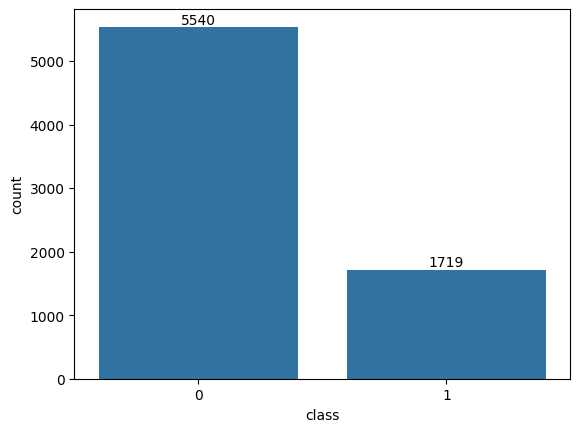

In [ ]:
# Visualize the distribution of classes (benign vs malware)
plt.figure()
ax = sns.countplot(data=data, x="class")
for container in ax.containers:
    ax.bar_label(container)

plt.show()

In [ ]:
# Split data into features and target
X = data.drop("class", axis=1)
y = data["class"]

# Stratified split to ensure both classes are represented
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution in the training set after stratified split
print("Training set class distribution after stratified split:")
print(y_train.value_counts())

Training set class distribution after stratified split:
class
0    4432
1    1375
Name: count, dtype: int64


In [ ]:
# Hyperparameter tuning for Random Forest using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Check if both classes are present in the training set
if y_train.nunique() > 1:
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)
else:
    print("Only one class found in training data. SMOTE will not be applied.")
    X_res, y_res = X_train, y_train  # No resampling, use the original data

# Check class distribution after applying SMOTE
print("Class distribution after applying SMOTE:")
print(pd.Series(y_res).value_counts())

Class distribution after applying SMOTE:
class
1    4432
0    4432
Name: count, dtype: int64


In [ ]:
# Train the Random Forest model using the best parameters from GridSearchCV
rf_tuned = grid_search.best_estimator_

In [ ]:
# Apply class weights to handle the class imbalance
rf_tuned = RandomForestClassifier(class_weight="balanced", **grid_search.best_params_)
rf_tuned.fit(X_res, y_res)

RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=200)

In [ ]:
# Evaluate training score
rf_train_score = rf_tuned.score(X_res, y_res)
print("Random Forest Training Score:", rf_train_score)

Random Forest Training Score: 0.9986462093862816


In [ ]:
# Cross-validation to check model performance
scores = cross_val_score(rf_tuned, X_res, y_res, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean()} ± {scores.std()}")

Cross-validation accuracy: 0.9763096815920778 ± 0.008030169358325647


In [ ]:
# Predict on the test set
rf_pred_test = rf_tuned.predict(X_test)

In [ ]:
# Calculate and print various metrics
rf_test_score = accuracy_score(rf_pred_test, y_test)
print("Random Forest Test Score:", rf_test_score)

Random Forest Test Score: 0.9621212121212122


In [ ]:
# Classification report
print(classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1108
           1       0.93      0.91      0.92       344

    accuracy                           0.96      1452
   macro avg       0.95      0.94      0.95      1452
weighted avg       0.96      0.96      0.96      1452



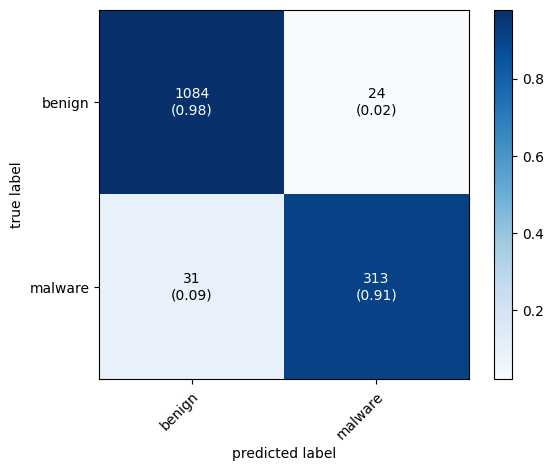

In [ ]:
# Confusion matrix plot
from sklearn.metrics import confusion_matrix
rf_cm = confusion_matrix(y_test, rf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=rf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
plt.show()

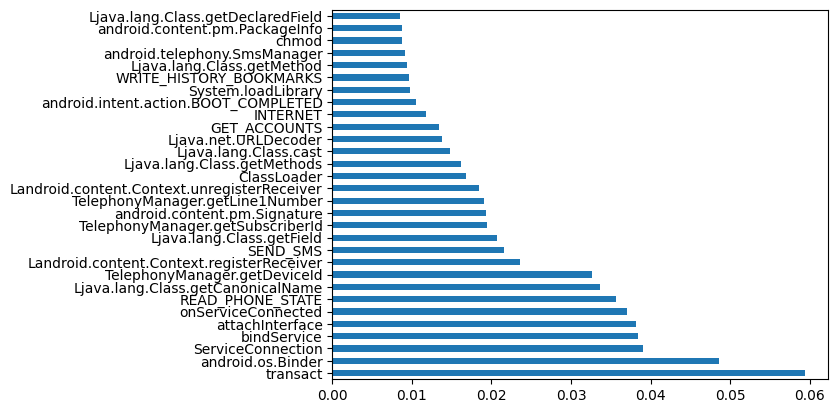

In [ ]:
    # Plot feature importances
    feat_importances = pd.Series(rf_tuned.feature_importances_, index=X.columns)
    feat_importances.nlargest(30).plot(kind='barh')
    plt.show()

In [ ]:
# Calibrate the model (optional step)
calibrated_rf = CalibratedClassifierCV(rf_tuned, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_res, y_res)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=30,
                                                        n_estimators=200))

In [ ]:
# Extract features from APK file for prediction
apk_file_path = "/content/Malware.apk"
permissions_list = feature_df[feature_df["Category"] == "Manifest Permission"].X.unique()
api_call_signatures = feature_df[feature_df["Category"] == "API call signature"].X.unique()
intents = feature_df[feature_df["Category"] == "Intent"].X.unique()
keywords = feature_df[feature_df["Category"] == "Commands signature"].X.unique()

In [ ]:
columns = ["filename"]
for col in data.columns:
    columns.append(col)

In [ ]:
test_df = pd.DataFrame(columns=columns)
test_df.loc[0, "filename"] = apk_file_path

In [ ]:
# Process APK file and extract features (permissions, API calls, intents, keywords)
a = APK(apk_file_path)
d = DalvikVMFormat(a.get_dex())
permissions = a.get_permissions()
manifest = a.get_android_manifest_xml()
intent_filters = manifest.findall(".//intent-filter")

In [ ]:
found_permissions = []
found_api_signatures = []
found_intents = []
found_keywords = []

In [ ]:
# Extract features related to permissions, API calls, intents, and commands
for permission in permissions:
    permission = permission.split(".")[-1]
    if permission in permissions_list:
        found_permissions.append(permission)

for permission in permissions_list:
    if permission in found_permissions:
        test_df[permission] = 1
    else:
        test_df[permission] = 0

for method in d.get_methods():
    descriptor = method.get_descriptor()

    if isinstance(descriptor, bytes):
        descriptor = descriptor.decode('utf-8')

    for api_call in api_call_signatures:
        if re.search(api_call, descriptor):
            found_api_signatures.append(api_call)

for api_call in api_call_signatures:
    if api_call in found_api_signatures:
        test_df[api_call] = 1
    else:
        test_df[api_call] = 0

for intent_filter in intent_filters:
    action_elements = intent_filter.findall(".//action")
    for action_element in action_elements:
        action_value = action_element.get("{http://schemas.android.com/apk/res/android}name")
        for intent in intents:
            if re.search(intent, action_value):
                found_intents.append(intent)

for intent in intents:
    if intent in found_intents:
        test_df[intent] = 1
    else:
        test_df[intent] = 0

for method in d.get_methods():
    for api_call in api_call_signatures:
        descriptor = method.get_descriptor().decode('utf-8')
        if re.search(api_call, descriptor):
            found_api_signatures.append(api_call)

for keyword in keywords:
    if keyword in found_keywords:
        test_df[keyword] = 1
    else:
        test_df[keyword] = 0

In [ ]:
# Preprocess test data for prediction
test_df = test_df.fillna(0)  # Fill missing values with 0

# Drop the filename column as it was added for identification
test_features = test_df.drop(columns=["filename"])

# Ensure the test data has the same columns as the training data (X)
test_features = test_features.reindex(columns=X.columns, fill_value=0)

In [ ]:
# Make predictions on the test data
prediction = rf_tuned.predict(test_features)

In [ ]:
# Output Prediction
if prediction[0] == 0:
    print("The APK file is predicted to be benign.")
else:
    print("The APK file is predicted to be malware.")

The APK file is predicted to be benign.


In [ ]:
import joblib

# Save the trained model (after tuning) to a joblib file
joblib.dump(rf_tuned, '/content/random_forest_malware_model.joblib')

print("Model saved successfully as 'random_forest_malware_model.joblib'")

Model saved successfully as 'random_forest_malware_model.joblib'


In [ ]:
import joblib

# Load the saved model from the joblib file
rf_tuned_loaded = joblib.load('/content/random_forest_malware_model.joblib')

# Ensure the test data is preprocessed correctly (same steps as before)
test_df = test_df.fillna(0)  # Fill missing values with 0

# Drop the filename column (this was used only for identification)
test_features = test_df.drop(columns=["filename"])

# Ensure the test data has the same columns as the training data (X)
test_features = test_features.reindex(columns=X.columns, fill_value=0)

# Make predictions using the loaded model
prediction = rf_tuned_loaded.predict(test_features)

# Output Prediction
if prediction[0] == 0:
    print("The APK file is predicted to be benign.")
else:
    print("The APK file is predicted to be malware.")


The APK file is predicted to be benign.
